## Import library

packages allowed for use during inference

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torchvision

import imageio as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from modules_v3 import UNet_conditional
from P1_CustomDataset import P1_CustomDataset
from P1_CombinedDataset import P1_CombinedDataset

packages during training

## Hyperparameters

In [2]:
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


## Define Custom Dataset

training dataset的mean & std

In [3]:
train_mean = [0.5, 0.5, 0.5]
train_std = [0.5, 0.5, 0.5]

建train transform和val transform

val transform和test transform一樣

In [4]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

用P1_CustomDataset分別產生兩個資料集的train dataset，再將兩個dataset合成一個dataset，並產生trainloader

In [5]:
train_dataset_MNISTM = P1_CustomDataset(csv_file='../hw2_data/digits/mnistm/train.csv', root_dir='../hw2_data/digits/mnistm/data', transform=transform_train)
train_dataset_SVHN = P1_CustomDataset(csv_file='../hw2_data/digits/svhn/train.csv', root_dir='../hw2_data/digits/svhn/data', transform=transform_train)
combined_dataset = P1_CombinedDataset(train_dataset_MNISTM, train_dataset_SVHN)

combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(len(combined_loader))

1059


In [6]:
# print shape
image_first_batch, label_first_batch = next(iter(combined_loader))  #get first batch's image & mask
label_dataset, label_image = label_first_batch
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_dataset.shape: ", label_dataset.shape)
print("label_image.shape: ", label_image.shape)
# get some values
print("normalized pixel value:", image_first_batch[3][0][9][8])
print("label_dataset (should be integer 0 ~ 1):",label_dataset[3])
print("label_image (should be integer 0 ~ 9):",label_image[3])

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([128, 3, 28, 28])
type(label_first_batch):  <class 'list'>
label_dataset.shape:  torch.Size([128])
label_image.shape:  torch.Size([128])
normalized pixel value: tensor(0.4118)
label_dataset (should be integer 0 ~ 1): tensor(1)
label_image (should be integer 0 ~ 9): tensor(7)


In [7]:
print("dataset label of first batch:", label_dataset) # two datasets are mixed together

dataset label of first batch: tensor([1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label of dataset: tensor(1)
label of image: tensor(4)
shape:  (28, 28, 3)


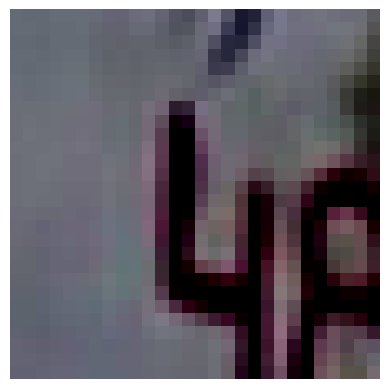

In [8]:
# visualize with normalization
idx = 15
first_image = image_first_batch[idx]
first_label_dataset = label_dataset[idx]
first_label_image = label_image[idx]
print("label of dataset:",first_label_dataset)
print("label of image:",first_label_image)

# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

print("shape: ",image_np.shape) # need to convert back to 28*28 during inference (in digit_classifier.py)

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

## Build Model

instance model and put it on device

In [9]:
net = UNet_conditional(size=28, time_dim=256, num_classes=20, device=device).to(device)

In [10]:
#print output shape
x = torch.randn(10,3,28,28).to(device) # dummy input也放到device
t = torch.randint(0, 500, (10,)).to(device)  # Ensure values are in range [0, 9]
y = torch.randint(0, 20, (10,)).to(device)
#dataset_label = torch.randint(0, 2, (10,)).to(device)
output = net(x, t, y)
print(output.shape)
print(x.dtype)
print(y.dtype)

torch.Size([10, 3, 28, 28])
torch.float32
torch.int64


## Training

Loss and Optimizer and epoch_n

In [16]:
# number of epoch
num_epochs = 50
# DDPM paper suggest using MSE as noise loss
criterion = nn.MSELoss()
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-5)

# Different base learning rate and update strategy #!!!!!!
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 10個epoch沒進步==> lr *= 0.5
#scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(combined_loader), eta_min = 1e-8) # update lr each batch

# total time steps
T = 400


#### DDPM training functions

alpha_t and alpha_hat_t of DDPM

In [17]:
# 1. beta
beta_1 = 1e-4
beta_T = 0.02
beta = torch.linspace(beta_1, beta_T, T) 
# 2. alpha
alpha = 1 - beta
# 3. alpha_hat
# alpha hat = [alpha[0], alpha[0]*alpha[1], alpha[0]*alpha[1]*alpha[2], ... ,alpha[0]*...*alpha[T-1])] 
alpha_hat = torch.zeros_like(alpha) # tensor with len T, alpha_hat.shape = T
alpha_hat[0] = alpha[0] # Set the first element
for i in range(1, alpha.shape[0]):
    alpha_hat[i] = alpha_hat[i - 1] * alpha[i]


torch.save(beta, './alpha_tensors/beta_tensor.pt')
torch.save(alpha, './alpha_tensors/alpha_tensor.pt')
torch.save(alpha_hat, './alpha_tensors/alpha_hat_tensor.pt')

functions

In [18]:
def noise_x_t(alpha_hat, x_0, t, epsilon):
    """given x[0](origin image) and t, return x[t](noisy image from x[0] by adding epsilon repeatly t times)"""
    """一步登天"""
    """epsilon.shape = x_0.shape = N*C*H*W,  t.shape = N"""
    """alpha_hat.shape = T, index t = 0 ~ T-1"""

    sqrt_alpha_hat = torch.sqrt(alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_alpha_hat.shape = N*1*1*1
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).unsqueeze(1).unsqueeze(1).unsqueeze(1) # sqrt_one_minus_alpha_hat.shape = N*1*1*1

    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * epsilon
    
    return x_t #x[t] is N*C*H*W

#### training loop (DDPM framework)

In [20]:
# Training Loop
model_version = 3    # version 3: combined 2 datasets to 1 dataset + change model to smaller one(reduce down3 & up1 layer) + T = 400
training_version = 1 # for name of checkpoint model # train的第幾次

train_loss_list = []
lr_list = []

beta = beta.to(device)
alpha = alpha.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0

    for images, label_dataset_image in tqdm(combined_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        # ========================================================== step1: x0 ~ q(x0) ===========================================================
        # x0 is original image: images
        dataset_label = label_dataset_image[0]
        image_label = label_dataset_image[1]
        images, dataset_label, image_label = images.to(device), dataset_label.to(device), image_label.to(device)# model, input output of model are moved to GPU during training
        N, C, H, W = images.shape[0], images.shape[1], images.shape[2], images.shape[3]

        # ==================================================== step2: t ~ Uniform({1,...,T}) =====================================================
        t_np = np.random.randint(0, T, size=(N,))  # Sample t from Uniform({0, ..., T-1}) # python is 0-indexing
        t = torch.from_numpy(t_np)
        t = t.to(device)

        # ======================================================= step3: epsilon ~ N(0, 1) =======================================================
        noise = torch.randn(N, C, H, W)  # Sample noise from normal distribution with mean 0 and standard deviation 1
        noise = noise.to(device)         # dtype = float32     # shape = N* C* H* W

        # ===================================== step4: take gradient descent step on noise and predict_noise =====================================
        x_t = noise_x_t(alpha_hat=alpha_hat, x_0=images, t=t, epsilon=noise)
        x_t = x_t.to(device)
        
        #predict_noise=N*C*H*W
        # version 3: combined 2 datasets to 1 dataset
        image_label = image_label + 10 * dataset_label
        image_label = image_label.to(device)
        
        if torch.rand(1).item() < 0.1:  # 10% chance to enter this block # 10% of training is unconditional training
            image_label = None 
        predict_noise = net(x=x_t, t=t, y=image_label) #x=N*C*H*W, t=N, y=N, 

        loss = criterion(noise, predict_noise) # MSE loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        train_loss += loss.item()

        #scheduler.step() # update lr each batch(cosine scheduler)
        


    train_loss /= len(combined_loader)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {train_loss:.4f}')
    print(f'Learning rate {scheduler.get_last_lr()[0]}')
    train_loss_list.append(train_loss)

    scheduler.step() # update lr each epoch(linear step scheduler)
    lr_list.append(scheduler.get_last_lr()[0])

# save the model state_dict
save_dir = os.path.join("../checkpoint_model", "P1", f'P1_model_ver{model_version}_{training_version}.pth')
torch.save(net.state_dict(), save_dir)
print(f'Saved model for epoch to {save_dir}')

Epoch 1/50: 100%|████████████████████████| 1059/1059 [04:11<00:00,  4.21batch/s]


Epoch 1/50 - Loss: 0.0815
Learning rate 0.0001


Epoch 2/50: 100%|████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 2/50 - Loss: 0.0528
Learning rate 0.0001


Epoch 3/50: 100%|████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 3/50 - Loss: 0.0462
Learning rate 0.0001


Epoch 4/50: 100%|████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 4/50 - Loss: 0.0426
Learning rate 0.0001


Epoch 5/50: 100%|████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 5/50 - Loss: 0.0404
Learning rate 0.0001


Epoch 6/50: 100%|████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 6/50 - Loss: 0.0393
Learning rate 0.0001


Epoch 7/50: 100%|████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 7/50 - Loss: 0.0378
Learning rate 0.0001


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 8/50 - Loss: 0.0366
Learning rate 0.0001


Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 9/50 - Loss: 0.0361
Learning rate 0.0001


Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 10/50 - Loss: 0.0357
Learning rate 0.0001


Epoch 11/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 11/50 - Loss: 0.0344
Learning rate 5e-05


Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 12/50 - Loss: 0.0344
Learning rate 5e-05


Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 13/50 - Loss: 0.0339
Learning rate 5e-05


Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 14/50 - Loss: 0.0338
Learning rate 5e-05


Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 15/50 - Loss: 0.0337
Learning rate 5e-05


Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 16/50 - Loss: 0.0333
Learning rate 5e-05


Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.21batch/s]


Epoch 17/50 - Loss: 0.0333
Learning rate 5e-05


Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 18/50 - Loss: 0.0328
Learning rate 5e-05


Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 19/50 - Loss: 0.0328
Learning rate 5e-05


Epoch 20/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 20/50 - Loss: 0.0330
Learning rate 5e-05


Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 21/50 - Loss: 0.0324
Learning rate 2.5e-05


Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 22/50 - Loss: 0.0323
Learning rate 2.5e-05


Epoch 23/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 23/50 - Loss: 0.0323
Learning rate 2.5e-05


Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 24/50 - Loss: 0.0320
Learning rate 2.5e-05


Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 25/50 - Loss: 0.0321
Learning rate 2.5e-05


Epoch 26/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 26/50 - Loss: 0.0322
Learning rate 2.5e-05


Epoch 27/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 27/50 - Loss: 0.0321
Learning rate 2.5e-05


Epoch 28/50: 100%|███████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 28/50 - Loss: 0.0319
Learning rate 2.5e-05


Epoch 29/50: 100%|███████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 29/50 - Loss: 0.0320
Learning rate 2.5e-05


Epoch 30/50: 100%|███████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 30/50 - Loss: 0.0315
Learning rate 2.5e-05


Epoch 31/50: 100%|███████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 31/50 - Loss: 0.0314
Learning rate 1.25e-05


Epoch 32/50: 100%|███████████████████████| 1059/1059 [04:12<00:00,  4.20batch/s]


Epoch 32/50 - Loss: 0.0319
Learning rate 1.25e-05


Epoch 33/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 33/50 - Loss: 0.0315
Learning rate 1.25e-05


Epoch 34/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 34/50 - Loss: 0.0315
Learning rate 1.25e-05


Epoch 35/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 35/50 - Loss: 0.0313
Learning rate 1.25e-05


Epoch 36/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.21batch/s]


Epoch 36/50 - Loss: 0.0316
Learning rate 1.25e-05


Epoch 37/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 37/50 - Loss: 0.0314
Learning rate 1.25e-05


Epoch 38/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 38/50 - Loss: 0.0314
Learning rate 1.25e-05


Epoch 39/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 39/50 - Loss: 0.0312
Learning rate 1.25e-05


Epoch 40/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 40/50 - Loss: 0.0312
Learning rate 1.25e-05


Epoch 41/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 41/50 - Loss: 0.0311
Learning rate 6.25e-06


Epoch 42/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 42/50 - Loss: 0.0310
Learning rate 6.25e-06


Epoch 43/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 43/50 - Loss: 0.0310
Learning rate 6.25e-06


Epoch 44/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.21batch/s]


Epoch 44/50 - Loss: 0.0311
Learning rate 6.25e-06


Epoch 45/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 45/50 - Loss: 0.0310
Learning rate 6.25e-06


Epoch 46/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 46/50 - Loss: 0.0308
Learning rate 6.25e-06


Epoch 47/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 47/50 - Loss: 0.0312
Learning rate 6.25e-06


Epoch 48/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 48/50 - Loss: 0.0309
Learning rate 6.25e-06


Epoch 49/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]


Epoch 49/50 - Loss: 0.0310
Learning rate 6.25e-06


Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1059/1059 [04:11<00:00,  4.20batch/s]

Epoch 50/50 - Loss: 0.0310
Learning rate 6.25e-06
Saved model for epoch to ../checkpoint_model/P1/P1_model_ver3_1.pth


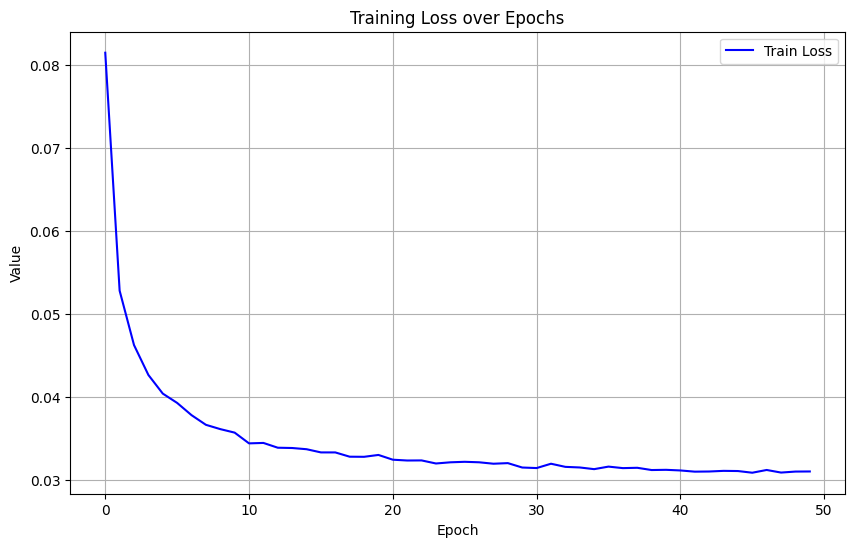

In [21]:
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss_list, label='Train Loss', color='blue')

# Adding titles and labels
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid()
# Show the plot
plt.show()

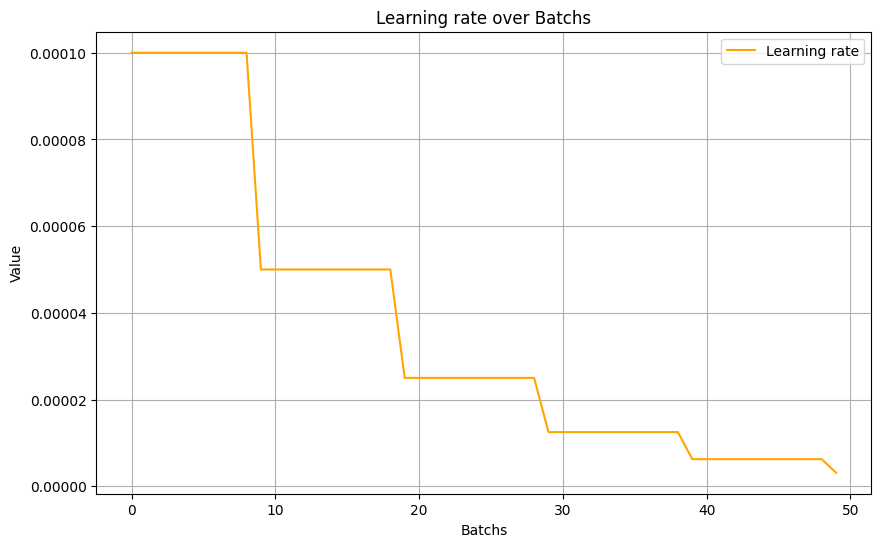

In [22]:
plt.figure(figsize=(10, 6))
# Plot Learning rate
plt.plot(lr_list, label='Learning rate', color='orange')


# Adding titles and labels
plt.title('Learning rate over Batchs')
plt.xlabel('Batchs')
plt.ylabel('Value')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [23]:
print(train_loss_list)

[0.08148769845058605, 0.052788467945863435, 0.046236004961814604, 0.04262993814523936, 0.04038345539719007, 0.039258584965854125, 0.037784216243059596, 0.03661885713090781, 0.036099773966219204, 0.035676536622533714, 0.034381049650882185, 0.03443385678676781, 0.033856621370901466, 0.03382154358542112, 0.03367606484937122, 0.03329094706544682, 0.03328915706873503, 0.032773489317205064, 0.032761429435625405, 0.03298526971202565, 0.03241222808920234, 0.03231438229650231, 0.03232502602955381, 0.03195526873617239, 0.03209744568481493, 0.03215832037392149, 0.032100019195557654, 0.03192657022802924, 0.031999394879786335, 0.031468830723931085, 0.031404030765208917, 0.03192574259797788, 0.031547970186859176, 0.03147521319801763, 0.0312724411944886, 0.03157885154890384, 0.0313962033357932, 0.03143692366441147, 0.031164958756469803, 0.031191992567284024, 0.03111520139773124, 0.03097041929360546, 0.03098890001729933, 0.031065791289518193, 0.031044766251472677, 0.030841740782216992, 0.0311729948637